In [1]:
#default_exp self_supervised

In [2]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *

Loading imports


In [3]:
torch.cuda.set_device(1)

## Vanila Dataset

In [4]:
#export
def get_ss_gen(fns, bs, img_tfm, splits, nw=8, test=False):
    tfms = [[img_tfm, ToTensor], [fn2label,EncodedMultiCategorize(htypes)]]
    if test: tfms = [tfms[0]]
    dsets = Datasets(fns, tfms, splits=splits)
    batch_tfms = L(IntToFloatTensor)
    return dsets.dataloaders(bs=bs, num_workers=nw, after_batch=batch_tfms)

In [5]:
#export
def get_ss_data(bs, splits, img_dir=path_jpg256, **kwargs):
    return get_ss_gen(L(list(Meta.df_comb.index)), bs=bs, img_tfm=get_pil_fn(path/img_dir), 
                      splits=splits, **kwargs)

In [6]:
dls = get_ss_data(32, splits=Meta.splits_sample)

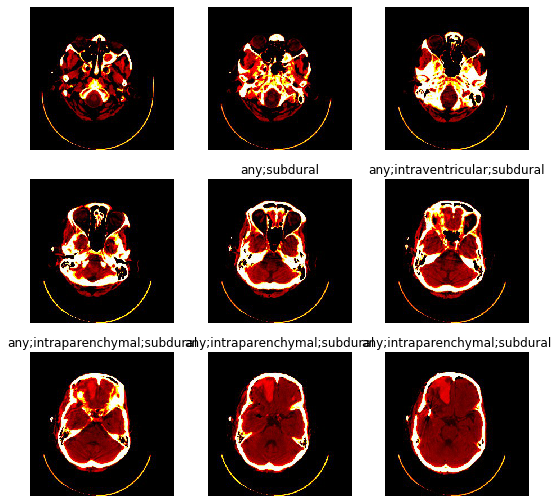

In [7]:
dls.valid.show_batch()

In [8]:
xb,yb = dls.one_batch(); xb.shape

torch.Size([32, 3, 256, 256])

In [9]:
#export
def pipe_update_size(pipe, size):
    for tf in pipe.fs:
        if isinstance(tf, RandomResizedCropGPU):
            tf.size = size

In [10]:
#export
def get_aug_pipe(size, min_scale=0.5, **kwargs):
    tfms = [Normalize.from_stats(mean,std)] + aug_transforms(size=size, min_scale=min_scale, **kwargs)
    return Pipeline(tfms)

In [11]:
p = get_aug_pipe(size=128)
p(xb).shape

torch.Size([32, 3, 128, 128])

In [12]:
p

Pipeline: AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> Normalize

In [13]:
pipe_update_size(p, 384)
p(xb).shape

torch.Size([32, 3, 384, 384])

## Loss 

### Taken from here: https://github.com/adambielski/siamese-triplet/blob/master/losses.py

In [14]:
#export
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


## Sanity Checking Triple loss

In [15]:
xb,yb = dls.one_batch()

In [16]:
tloss = TripletLoss(margin=0.5)

In [17]:
# Pos = Pos
tloss(xb, xb, xb.flip(dims=[0]))

tensor(0.3983, device='cuda:1')

In [18]:
# Pos = Neg
tloss(xb, xb.flip(dims=[0]), xb)

tensor(0.8409, device='cuda:1')

In [19]:
aug = get_aug_pipe(256)
tloss(xb, aug(xb), xb.flip(dims=[0]))

tensor(3.5308, device='cuda:1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


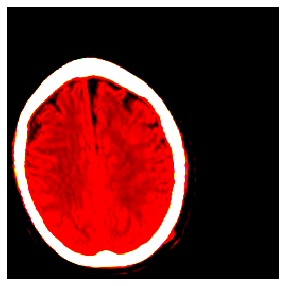

In [20]:
show_image(aug(xb)[0])

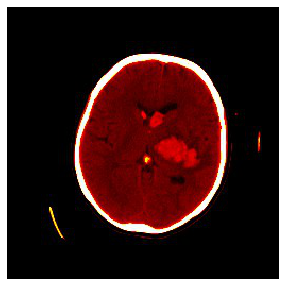

In [21]:
show_image(xb.flip(dims=[0])[0])

## Callbacks

In [22]:
#export
class SSModel(nn.Sequential):
    def __init__(self, model:nn.Sequential): super().__init__(*model)
        
    def features(self, x):
        return self[1][:2](self[0](x))
    
    def logits(self, x):
        return self[1][2:](x)
        
    def forward(self, *args):
        feats = [self.features(x) for x in args]
        logits = [self.logits(x) for x in feats]
        return tuple(feats), tuple(logits)

In [23]:
#export
class CombinedSSLoss(nn.Module):
    def __init__(self, ss_loss_func, orig_loss_func):
        super().__init__()
        store_attr(self, 'ss_loss_func,orig_loss_func')
        
    def ss_loss(self, preds, labels): return self.ss_loss_func(preds, labels)
    def orig_loss(self, preds, labels):
        feats, (logits_targ, logits_pos) = preds
        return self.orig_loss_func(logits_targ, labels)
        
    def forward(self, preds, labels):
        return self.ss_loss(preds, labels) + self.orig_loss(preds, labels)

In [24]:
#export
def accuracy_ss(preds, targ, thresh=0.5, sigmoid=True):
    _, (inp, _) = preds
    return accuracy_any(inp, targ, thresh, sigmoid)

In [25]:
#export
class SSCallback(Callback):
    run_before=Recorder
    def __init__(self, loss_func, size=256, aug_targ=None, aug_pos=None, combined_loss=False):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size, min_scale=0.7))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size, min_scale=0.4))
        self.loss_func = loss_func
        self.combined_loss = combined_loss
        
        self.orig_loss_func = None
        self.orig_metrics = None
        
    def update_size(self, size):
        pipe_update_size(self.aug_targ, size)
        pipe_update_size(self.aug_pos, size)
        
    def begin_fit(self): 
        self.learn.model = SSModel(self.learn.model)
        self.orig_loss_func = self.learn.loss_func
        self.learn.loss_func = CombinedSSLoss(self.loss_func, self.learn.loss_func) if self.combined_loss else self.loss_func
        
        if self.combined_loss:
            self.orig_metrics = self.learn.metrics
            c = self.learn.loss_func
            self.learn.metrics = self.orig_metrics + [accuracy_ss, c.ss_loss, c.orig_loss]
            
    def after_fit(self): 
        self.learn.model = nn.Sequential(*self.learn.model)
        self.learn.loss_func = self.orig_loss_func
        self.learn.metrics = self.orig_metrics
        
    def set_split(self, split_idx):
        self.aug_targ.split_idx = split_idx
#         self.aug_pos.split_idx = split_idx # always keep augmentation
    def begin_validate(self): self.set_split(1)
    def begin_train(self): self.set_split(0)
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = xb_targ, xb_pos
        

## Triplet Loss

In [26]:
#export
class SSTripletLoss(TripletLoss):
    def forward(self, preds, labels, size_average=True):
        (anchor, positive), logits = preds
        negative = positive.flip(dims=[0])
        return super().forward(anchor, positive, negative, size_average)


## Training

In [27]:
# size=128
# dls = get_ss_data(128, splits=Meta.splits_sample)
# cb = SSCallback(SSTripletLoss())
# learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
#             opt_func=Adam, metrics=[], cbs=cb)


# learn.fit_one_cycle(1)

## Sanity Check Contrastive Loss

In [117]:
#export
# https://github.com/adambielski/siamese-triplet/blob/master/losses.py
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
#         distances = (output2 - output1).pow(2).sum(1)  # squared distances
        distances = F.pairwise_distance(output1, output2, keepdim=True).sum(1)  # squared distances
#         distances = F.cosine_similarity(output1, output2, dim=-1).pow(2).sum(-1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [119]:
import pdb

In [120]:
# Original code
# https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb


class CosineContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
#         euclidean_distance = F.cosine_similarity(output1, output2, dim=-1)
#         pdb.set_trace()
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [121]:
# https://stackoverflow.com/questions/47107589/how-do-i-use-a-bytetensor-in-a-contrastive-cosine-loss-function
class CosineContrastiveLoss2(nn.Module):
    """
    Cosine contrastive loss function.
    Based on: http://anthology.aclweb.org/W16-1617
    Maintain 0 for match, 1 for not match.
    If they match, loss is 1/4(1-cos_sim)^2.
    If they don't, it's cos_sim^2 if cos_sim < margin or 0 otherwise.
    Margin in the paper is ~0.4.
    """

    def __init__(self, margin=0.4):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        cos_sim = F.cosine_similarity(output1, output2)
        loss_cos_con = torch.mean((label) * torch.div(torch.pow((1.0-cos_sim), 2), 4) +
                                    (1-label) * torch.pow(cos_sim * torch.lt(cos_sim, self.margin), 2))
        return loss_cos_con

In [122]:
closs = ContrastiveLoss()
ccloss = CosineContrastiveLoss2()

In [309]:
targ = torch.randn(4, 8) # bs x features
aug = targ + 0.1 # bs x feat
# aug = targ
# aug = targ[:1].repeat(8,1)
targ.shape, aug.shape

(torch.Size([4, 8]), torch.Size([4, 8]))

In [310]:
def cosine_sim(output1, output2):
    num = output1.T @ output2
    denom = torch.norm(output1) * torch.norm(output2)
    out = num / denom
    return out

In [311]:
output1 = targ[0]
output2 = aug[1]
c_sim = F.cosine_similarity(output1, output2, dim=-1)
c_sim, cosine_sim(output1, output2)

(tensor(-0.0647), tensor(-0.0647))

In [312]:
output1 = targ[0]
output2 = aug
c_sim = F.cosine_similarity(output1, output2, dim=-1)
c_sim.view(1,-1)

tensor([[ 0.9957, -0.0647,  0.1607, -0.0650]])

In [313]:
labels = torch.tensor([0])

In [314]:
F.cross_entropy(c_sim.view(1,-1),labels.long())

tensor(0.7544)

In [315]:
# t0 -> aug
# t1 -> aug

In [326]:
targ

tensor([[ 0.5094, -1.3309,  0.4260,  0.1679,  2.1655, -0.1235, -1.1395, -1.0353],
        [ 0.2073, -0.2162,  0.7012,  0.9730, -0.5004, -0.7756,  0.2378, -0.1149],
        [ 0.2270, -0.6222,  0.7947,  1.0425, -0.0841,  0.6028, -0.2409,  0.5186],
        [-0.5216, -0.7756, -0.3479,  0.1614,  0.9840, -1.0217,  2.4246,  0.7001]])

In [339]:
targ.repeat(1,4).view(4,4,-1)

tensor([[[ 0.5094, -1.3309,  0.4260,  0.1679,  2.1655, -0.1235, -1.1395,
          -1.0353],
         [ 0.5094, -1.3309,  0.4260,  0.1679,  2.1655, -0.1235, -1.1395,
          -1.0353],
         [ 0.5094, -1.3309,  0.4260,  0.1679,  2.1655, -0.1235, -1.1395,
          -1.0353],
         [ 0.5094, -1.3309,  0.4260,  0.1679,  2.1655, -0.1235, -1.1395,
          -1.0353]],

        [[ 0.2073, -0.2162,  0.7012,  0.9730, -0.5004, -0.7756,  0.2378,
          -0.1149],
         [ 0.2073, -0.2162,  0.7012,  0.9730, -0.5004, -0.7756,  0.2378,
          -0.1149],
         [ 0.2073, -0.2162,  0.7012,  0.9730, -0.5004, -0.7756,  0.2378,
          -0.1149],
         [ 0.2073, -0.2162,  0.7012,  0.9730, -0.5004, -0.7756,  0.2378,
          -0.1149]],

        [[ 0.2270, -0.6222,  0.7947,  1.0425, -0.0841,  0.6028, -0.2409,
           0.5186],
         [ 0.2270, -0.6222,  0.7947,  1.0425, -0.0841,  0.6028, -0.2409,
           0.5186],
         [ 0.2270, -0.6222,  0.7947,  1.0425, -0.0841,  0.6028, -0

In [348]:
output1 = targ.repeat(1,4).view(4,*targ.shape)
output2 = aug
c_sim = F.cosine_similarity(output1, output2, dim=-1)
output2.shape, c_sim.shape

(torch.Size([4, 8]), torch.Size([4, 4]))

In [350]:
[F.cosine_similarity(o, aug, dim=-1) for o in targ]

[tensor([ 0.9957, -0.0647,  0.1607, -0.0650]),
 tensor([-0.0488,  0.9849,  0.4385,  0.1674]),
 tensor([ 0.2253,  0.5234,  0.9907, -0.0832]),
 tensor([-0.0454,  0.1868, -0.0893,  0.9961])]

In [349]:
c_sim

tensor([[ 0.9957, -0.0647,  0.1607, -0.0650],
        [-0.0488,  0.9849,  0.4385,  0.1674],
        [ 0.2253,  0.5234,  0.9907, -0.0832],
        [-0.0454,  0.1868, -0.0893,  0.9961]])

In [317]:
output1

tensor([[ 0.5094, -1.3309,  0.4260,  0.1679,  2.1655, -0.1235, -1.1395, -1.0353],
        [ 0.2073, -0.2162,  0.7012,  0.9730, -0.5004, -0.7756,  0.2378, -0.1149],
        [ 0.2270, -0.6222,  0.7947,  1.0425, -0.0841,  0.6028, -0.2409,  0.5186],
        [-0.5216, -0.7756, -0.3479,  0.1614,  0.9840, -1.0217,  2.4246,  0.7001]])

In [318]:
output2

tensor([[[ 0.6094, -1.2309,  0.5260,  0.2679,  2.2655, -0.0235, -1.0395,
          -0.9353],
         [ 0.3073, -0.1162,  0.8012,  1.0730, -0.4004, -0.6756,  0.3378,
          -0.0149],
         [ 0.3270, -0.5222,  0.8947,  1.1425,  0.0159,  0.7028, -0.1409,
           0.6186],
         [-0.4216, -0.6756, -0.2479,  0.2614,  1.0840, -0.9217,  2.5246,
           0.8001]],

        [[ 0.6094, -1.2309,  0.5260,  0.2679,  2.2655, -0.0235, -1.0395,
          -0.9353],
         [ 0.3073, -0.1162,  0.8012,  1.0730, -0.4004, -0.6756,  0.3378,
          -0.0149],
         [ 0.3270, -0.5222,  0.8947,  1.1425,  0.0159,  0.7028, -0.1409,
           0.6186],
         [-0.4216, -0.6756, -0.2479,  0.2614,  1.0840, -0.9217,  2.5246,
           0.8001]],

        [[ 0.6094, -1.2309,  0.5260,  0.2679,  2.2655, -0.0235, -1.0395,
          -0.9353],
         [ 0.3073, -0.1162,  0.8012,  1.0730, -0.4004, -0.6756,  0.3378,
          -0.0149],
         [ 0.3270, -0.5222,  0.8947,  1.1425,  0.0159,  0.7028, -0

In [288]:
c_sim

tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]])

In [265]:
num.shape

torch.Size([])

In [144]:
output1.T**output2

tensor([[    nan,     nan,  0.7673,  ...,     nan,  1.2137,  0.8494],
        [    nan,     nan,  1.9966,  ...,     nan,  1.0438,  0.4329],
        [    nan,     nan,  2.3906,  ...,     nan,  1.5588,  0.4299],
        ...,
        [    nan,     nan, 30.5645,  ...,     nan,  0.9310,  7.5514],
        [    nan,     nan,  0.4015,  ...,     nan,  0.7978,  0.3439],
        [    nan,     nan,  7.6584,  ...,     nan,  1.1348,  0.3384]])

In [142]:
c_sim

tensor([ 1.0000, -0.0127,  0.0088, -0.1296,  0.0272,  0.1920,  0.0056,  0.0714])

In [124]:
# closs(targ[:2], aug[:2], torch.zeros(2))

In [125]:
# output1 = targ
# output2 = aug
# # label = torch.zeros(targ.shape[0])
# # label[0] = 1
# label = torch.ones(targ.shape[0])
# margin = 2.0
# euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
# # euclidean_distance = F.cosine_similarity(output1, output2, dim=-1)
# # c_neg = (1-label) * torch.pow(euclidean_distance, 2)
# # c_pos = (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)

# c_pos = (label) * torch.pow(euclidean_distance, 2)
# c_neg = (1-label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)

# loss_contrastive = (c_neg + c_pos)
# # loss_contrastive.mean()
# loss_contrastive.mean()


# loss_contrastive, euclidean_distance.pow(2), c_neg, c_pos

In [126]:
labels = torch.zeros(targ.shape[0])
labels[0] = 1

# single target to rest of batch
closs(targ[:1], aug, labels), ccloss(targ[:1], aug, labels)

(tensor(0.1031), tensor(0.0027))

In [127]:
# 1-to-1 match targ -> aug. Loss should be 8x higher
labels = torch.ones(targ.shape[0])
closs(targ, aug, labels), ccloss(targ, aug, labels)

(tensor(0.8092), tensor(1.3323e-15))

In [128]:
# single targ -> all rand. Super High Loss
labels = torch.ones(targ.shape[0])
closs(targ[:1], aug, labels), ccloss(targ[:1], aug, labels)

(tensor(10.8931), tensor(0.2350))

### Batched contrastive loss

In [33]:
aug_bs = aug.repeat(8,1,1)
aug_bs.shape

torch.Size([8, 8, 256])

In [34]:
losses = []
for i in range(targ.shape[0]):
    bs = targ.shape[0]
    labels = torch.zeros(bs)
    labels[i] = 1 # set current target as the only positive label
    print(labels)
    losses.append(closs(targ[i], aug, labels))
torch.stack(losses).mean()

tensor([1., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1.])


tensor(0.1600)

In [35]:
# Sanity checking - setting wrong target as positive label
losses = []
for i in range(targ.shape[0]):
    bs = targ.shape[0]
    labels = torch.zeros(bs)
    labels[0] = 1 # set current target as the only positive label
    losses.append(closs(targ[i], aug, labels))
losses

[tensor(0.1600),
 tensor(34.0396),
 tensor(29.9417),
 tensor(31.3499),
 tensor(29.2392),
 tensor(32.6860),
 tensor(31.4645),
 tensor(29.9030)]

In [30]:
#export
class BatchContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.loss_func = ContrastiveLoss(margin)
        
    def forward(self, preds, labels):
        (anchor, positive), logits = preds
        
        bs = anchor.shape[0]
        losses = []
        for i in range(bs):
            labels = torch.zeros(bs, device=anchor.device)
            labels[i] = 1 # set current target as the only positive label
            losses.append(self.loss_func(anchor[i], positive, labels))
        return torch.stack(losses).mean()

## Training

In [ ]:
size=128
dls = get_ss_data(128, splits=Meta.splits_sample)
cb = SSCallback(BatchContrastiveLoss())
learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
            opt_func=Adam, metrics=[accuracy_ss], cbs=cb)


In [38]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.512545,0.820041,00:28


## Train Contrastive + Labels

In [34]:
size=128
dls = get_ss_data(128, splits=Meta.splits_sample)
cb = SSCallback(BatchContrastiveLoss(), combined_loss=True)
learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
            opt_func=Adam, metrics=[], cbs=cb)


In [35]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy_ss,ss_loss,orig_loss,time
0,1.129488,1.400029,0.787806,1.050643,0.349386,00:29


## Export

In [62]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 02_train_01_save_features.ipynb.
Converted 03_train3d.ipynb.
Converted 04_trainfull3d_deprecated.ipynb.
Converted 04_trainfull3d_labels.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 06_seutao_features.ipynb.
Converted 07_adni.ipynb.
Converted 07_adni_01.ipynb.
Converted 08_train_self_supervised.ipynb.
Converted 08_train_self_supervised_train_1.ipynb.
Converted 08_train_self_supervised_train_2_nocombined.ipynb.
Converted 08_train_self_supervised_train_3.ipynb.
Converted Tabular_02_FeatureImportance.ipynb.
Converted Untitled.ipynb.
